In [17]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/vit_xai/lib/python3.8/site-packages/'))

In [18]:
os.environ

environ{'SHELL': '/bin/bash',
        'JUPYTERHUB_API_TOKEN': '614d11864abf4398b6913c922b09ac36',
        'PY_VERSION': '3.8',
        'JUPYTERHUB_BASE_URL': '/jupyter/n11-04/',
        'NCCL_VERSION': '2.16',
        'PWD': '/home/vijayach',
        'TRT_VERSION': '8.5',
        'JUPYTERHUB_SERVER_NAME': '',
        'HOME': '/home/vijayach',
        'CUDNN_PATH': '/usr/local/cuda-11.8/cudnn-8.7',
        'LANG': 'en_US.UTF-8',
        'JPY_API_TOKEN': '614d11864abf4398b6913c922b09ac36',
        'JUPYTERHUB_SERVICE_PREFIX': '/jupyter/n11-04/user/vijayach/',
        'TRT_PATH': '/usr/local/cuda-11.8/tensorRT-8.5',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/jupyter/n11-04/user/vijayach/oauth_callback',
        'PYTHONPATH': '/scratch/vijayach/python/lib/python3.8/site-packages:/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages:/usr/local/jupyter/lib/python3.8/site-packages',
        'CPLUS_INCLUDE_PATH': '/scratch/vijayach/python/include:/usr/local/cuda-11.8/include:/usr/local

In [19]:
sys.path

['/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/experiments',
 '',
 '/scratch/vijayach/python/lib/python3.8/site-packages',
 '/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages/IPython/extensions',
 '/home/vijayach/.ipython']

In [20]:
!nvidia-smi

Sun Sep  1 18:13:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:03:00.0 Off |                    0 |
|  0%   23C    P8              20W / 300W |      4MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

# Import libraries

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from transformers import TFViTForImageClassification, ViTImageProcessor
import tensorflow as tf
from datasets import load_dataset
from skimage.util import view_as_blocks
from numpy.linalg import norm
from itertools import combinations
import shutil
import itertools
import time, os, csv
import pandas as pd

# Load data

In [23]:
val_data = load_dataset("frgfm/imagenette", "full_size", trust_remote_code=True,split='validation')

In [24]:
val_data.shuffle()

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

# Get concepts

In [9]:
concepts = [[],[],[],[],[],[],[],[],[],[]]
labels = []
n_examples = 20

for item in val_data:
    if np.array(item['image']).shape[-1]==3: # only look at images with 3 channels
        if (item['label']==0) & (len(concepts[0])<n_examples): #"tench"       # get the correct label
            labels.append(0)
            concepts[0].append([np.array(item['image']),item['label']])
        elif (item['label']==1) & (len(concepts[1])<n_examples): #"English springer"
            labels.append(217)
            concepts[1].append([np.array(item['image']),item['label']])
        elif (item['label']==2) & (len(concepts[2])<n_examples): #"cassette player"
            labels.append(482)
            concepts[2].append([np.array(item['image']),item['label']])
        elif (item['label']==3) & (len(concepts[3])<n_examples): #"chain saw"
            labels.append(491)
            concepts[3].append([np.array(item['image']),item['label']])
        elif (item['label']==4) & (len(concepts[4])<n_examples): #"church"
            labels.append(497)
            concepts[4].append([np.array(item['image']),item['label']])
        elif (item['label']==5) & (len(concepts[5])<n_examples): #"French horn"
            labels.append(566)
            concepts[5].append([np.array(item['image']),item['label']])
        elif (item['label']==6) & (len(concepts[6])<n_examples): #"garbage truck"
            labels.append(569)
            concepts[6].append([np.array(item['image']),item['label']])
        elif (item['label']==7) & (len(concepts[7])<n_examples): # "gas pump"
            labels.append(571)
            concepts[7].append([np.array(item['image']),item['label']])
        elif (item['label']==8) & (len(concepts[8])<n_examples): # "golf ball"
            labels.append(574)
            concepts[8].append([np.array(item['image']),item['label']])
        elif (item['label']==9) & (len(concepts[9])<n_examples): #"parachute"
            labels.append(701)
            concepts[9].append([np.array(item['image']),item['label']])

In [10]:
def print_examples(concept):
  for i in range(0,10):
    plt.subplot(1,10,i+1)
    plt.imshow(concept[i][0])
    plt.axis("off")

  plt.tight_layout()
  plt.show()

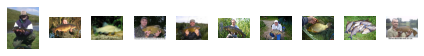

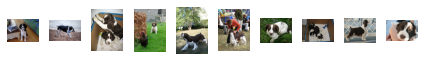

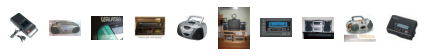

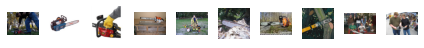

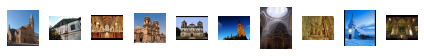

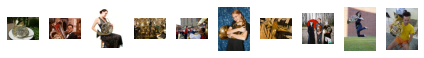

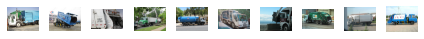

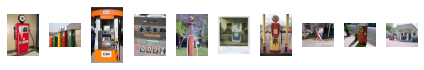

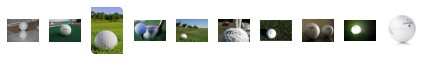

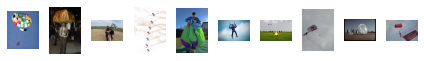

In [11]:
# for each class take the first n_examples images to form concept
for concept in concepts:
    print_examples(concept)

# Load pretrained model

In [12]:
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

image_processor = ViTImageProcessor()

2024-08-19 10:40:52.760892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:03:00.0, compute capability: 8.6
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [13]:
model.summary(expand_nested=True)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769000    
                                                                 
Total params: 86567656 (330.23 MB)
Trainable params: 86567656 (330.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Concept embeddings

In [14]:
#  average the embedding for a concept -> concept embedding
def average_embedding(embedding):
    embedding = embedding.numpy() # (20, 197, 768)
    embedding = embedding[:,1:,:] # drop CLS -> (20, 196, 768)
    embedding = embedding.mean(axis=0) # mean over batch
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)

    return embedding

# embedding of one example image of a concept
def image_embedding(embedding):
    embedding = embedding.numpy() # (197, 768)
    embedding = embedding[1:,:] # drop CLS -> (196, 768)
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)

    return embedding


# average the embedding for a concept -> concept embedding, only using k most relevant patches
def average_embedding_top_k(embedding, k, relevances, modus):
    # embedding (20, 197, 768)
    # relevances  (20,196)

    avg = []
    for i, relevance in enumerate(relevances): # relevance: (196,) -> relevances are for all examples of a concept; i--> ith image of a concept
        # take only k most important patches
        if modus == "top": # normal top-k selection
            _, indices = tf.math.top_k(relevance, k=k, sorted=True)
        elif modus == "bottom": # flipped top-k selection
            _, indices = tf.math.top_k(-1*relevance, k=k, sorted=True)
        elif modus == "random": # random selection
            indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
        else:
            raise "Modus not supported"

        indices = indices.numpy() # (30,)
        intermediate = embedding[i,1:,:].numpy() # (197, 768) # take embedding of ith example corresponding to relevance, remove CLS
        intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
        intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
        avg.append(intermediate)  # avg embedding of image
    avg = np.array(avg).mean(axis=0) # mean over examples (20, 768) -> (768,) avg embedding of whole concept

    return avg

# embedding of one example image of a concept only using top k most relevant patches
def image_embedding_top_k(embedding, k, relevances, modus):
    # embedding (197, 768)
    # relevances  (196)

    # take only k most important patches
    if modus == "top": # normal top-k selection
        _, indices = tf.math.top_k(relevances, k=k, sorted=True)
    elif modus == "bottom": # flipped top-k selection
        _, indices = tf.math.top_k(-1*relevances, k=k, sorted=True)
    elif modus == "random": # random selection
        indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
    else:
        raise "Modus not supported"

    indices = indices.numpy() # (30,)
    intermediate = embedding[1:,:].numpy() # (197, 768) #  remove CLS
    intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
    intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)

    return intermediate

In [15]:
def get_embeddings_and_attentions(concepts_selected):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts_selected:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []
    # for each concept in concept_nums(4): for each layer (12): (20,12,197,197)
    attentions_list = []
    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        attentions_list.append(pred.attentions)

    return embeddings_list, attentions_list


def get_embeddings(concepts):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []

    for pred in preds:
        embeddings_list.append(pred.hidden_states)

    return embeddings_list

## Finding a scale for the distances

In [16]:
# for every concept (10), for every layer (13): (20,197,768)
embeddings_list_scales = get_embeddings(concepts)
scales = tf.norm(embeddings_list_scales, axis=-1) # (10,13,20,197)
scales = np.mean(scales, axis=-1) # (10,13,20)
scales = np.mean(scales, axis=-1) # (10,13)

2024-08-19 10:41:39.058157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-08-19 10:41:39.236123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [17]:
scales = np.mean(scales, axis=0) #(13,)
scales = scales[:12] # drop last layer (12,)
scales

array([ 18.700756,  28.894363,  33.02797 ,  38.943707,  44.17913 ,
        58.10563 , 106.81632 , 148.6032  , 160.7162  , 172.59256 ,
       193.50545 , 248.28366 ], dtype=float32)

## Patch selection

In [18]:
k = 50
concept_nums = np.array([0,1,2,3,4,5,6,7,8,9])
concepts_selected = [concepts[i] for i in concept_nums]
layer_num = 0

embeddings_list, attentions_list = get_embeddings_and_attentions(concepts_selected)


# for each concept in concept_nums (4): for each layer (13): avg embedding = 197 values
#avg_embeddings_list = []
#for embeddings in embeddings_list:
#  avg_embeddings_list.append(average_embedding(embeddings[layer_num]))

### Attention Rollout

In [19]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py

def rollout(attentions, discard_ratio, head_fusion, layer_num):
  # attentions: for 12 layers: (20, 12, 197, 197) = (batch_size, n_heads, sequence_len, sequence_len)
  result = tf.eye(attentions[0].shape[-1]) # result.shape=(197,197), attentions[0].shape (1, 12, 197, 197)
  for i, attention in enumerate(attentions[::-1]):
    if i + layer_num == 13: # do rollout only until specified layer -------------------
        break
    if head_fusion == "mean":
      attention_heads_fused = attention.numpy().mean(axis=1)
    elif head_fusion == "max":
      attention_heads_fused = attention.numpy().max(axis=1)[0]
    elif head_fusion == "min":
      attention_heads_fused = attention.numpy().min(axis=1)#[0]
    else:
      raise "Attention head fusion type Not supported"

    # attention_heads_fused.shape -> (1,197,197)

    # Drop the lowest attentions, but
    # don't drop the class token
    flat = attention_heads_fused.reshape(attention_heads_fused.shape[0], -1) # flat.shape -> (1, 38809)
    _, indices = tf.math.top_k(flat, k=int(flat.shape[-1]*discard_ratio), sorted=False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = tf.eye(attention_heads_fused.shape[-1]) #I.shape -> (197,197)
    a = (attention_heads_fused + 1.0*I)/2
    a = a / tf.math.reduce_sum(a, -1)

    result = tf.matmul(a, result) # (1,197,197)

  # Look at the total attention between the class token,
  # and the image patches
  #print(result.shape)
  mask = result[0,0,1:]

  return mask.numpy()

In [20]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="max",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        #for name, module in self.model.named_modules():
           # if attention_layer_name in name:
               # module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor, layer_num):
        self.attentions = []
        output = self.model(input_tensor, output_attentions=True)

        return rollout(output.attentions, self.discard_ratio, self.head_fusion, layer_num)

### Relevances

#### Attention relevance - Class token in different layers

In [21]:
def get_attention_relevance(attentions, layer_num):
    # attentions --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens

    # basic attention: CLS at different layers
    # for each concept: attention of layer [0,11], mean over heads
    ## attentions[layer_num].numpy() --> extracting attention of a layer: (12, 20, 12, 197, 197) -> (20, 12, 197, 197)
    ## taking mean attention over all heads: (20, 12, 197, 197) -> (20, 197, 197
    att = attentions[layer_num].numpy().mean(axis=1)
    # attention from CLS token to all other patches
    att = att[:,0,1:] # Shape: (20, 196)

    return att # (20,196)



#### Attention relevance - Class token in different layers (with rollout)

In [22]:
def get_rollout_relevance(concept, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)
    x_concept,_ = zip(*concept)
    input = image_processor(x_concept, return_tensors="tf").pixel_values

    # for each example (20):  196 relevance values
    masks = []
    for i in range(len(concept)):
        mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
        masks.append(mask)

    return masks

#### Attention relevance - Aggregated attention in different layers

In [23]:
def get_agg_attention_relevance(attentions_list, layer_num, aggregation_type='max'):
    # attentions_list --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens
    # aggregation types (max, min, mean)

    # Extract the attentions for the specific layer
    layer_attentions = attentions_list[layer_num].numpy()  # Shape: (20, 12, 197, 197)

    # Initialize array to store the attention relevance scores for each image
    agg_attention_relevances = np.zeros((layer_attentions.shape[0], layer_attentions.shape[2] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_attentions.shape[0]):
        # Extract the attention values for the current image, excluding the CLS token
        image_attentions = layer_attentions[i, :, 1:, 1:]  # Shape: (12, 196, 196) - 12 heads, 196 tokens (excluding CLS), 196 tokens (excluding CLS)

        # Calculate the aggregated attention over all heads for each token (excluding CLS token)
        # First, take the aggregated attention across the heads
        # Then, take the aggregated attention attention value for each token
        if aggregation_type == 'max':
            # Calculate the maximum attention over all heads for each token (excluding CLS token)
            max_attention_across_heads = np.max(image_attentions, axis=0)  # Shape after max across heads: (196, 196)
            agg_attention_relevance = np.max(max_attention_across_heads, axis=1)  # Shape after max across tokens: (196,)
        elif aggregation_type == 'min':
            # Calculate the minimum attention over all heads for each token (excluding CLS token)
            min_attention_across_heads = np.min(image_attentions, axis=0)  # Shape after min across heads: (196, 196)
            agg_attention_relevance = np.min(min_attention_across_heads, axis=1)  # Shape after min across tokens: (196,)
        elif aggregation_type == 'mean':
            # Calculate the mean attention over all heads for each token (excluding CLS token)
            mean_attention_across_heads = np.mean(image_attentions, axis=0)  # Shape after mean across heads: (196, 196)
            agg_attention_relevance = np.mean(mean_attention_across_heads, axis=1)  # Shape after mean across tokens: (196,)
        else:
            raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

        # Store the relevance scores for the current image
        agg_attention_relevances[i] = agg_attention_relevance

    return agg_attention_relevances  # Shape: (20, 196)

#### Gradient relevance

In [24]:
def get_gradient_relevance_per_image(example, layer_num):
    input = image_processor(example, return_tensors="tf").pixel_values

    with tf.GradientTape() as tape:
        tape.watch(input)
        preds = model(input, output_hidden_states=True)

    #get gradient w.r.t patch embeddings
    grads = tape.gradient(preds.logits, preds.hidden_states[layer_num])
    grads = np.array(grads)
    grads = np.where(grads >= 0, grads, 0) # (1,197,768)

    grads = grads.mean(axis=-1) # mean over 768 values -> avg. gradient for a patch (1,197)


    return grads[0,1:] # remove CLS token


def get_gradient_relevance(concept, layer_num):
    x_concept,_ = zip(*concept)

    grads_list = []

    for i in range(len(x_concept)):
        grads_list.append(get_gradient_relevance_per_image(x_concept[i], layer_num))

    return grads_list


#### Embedding relevance

In [25]:
def get_embedding_relevance(embeddings_list, layer_num):
    # embeddings_list --> (13, 20, 197, 768) - embeddings of all 20 images of a concept, across 13 layers

    # Extract the embeddings for the specific layer
    layer_embeddings = embeddings_list[layer_num].numpy()  # Shape: (20, 197, 768)

    # Initialize arrays to store the relevance scores for each image
    embedding_relevances = np.zeros((layer_embeddings.shape[0], layer_embeddings.shape[1] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_embeddings.shape[0]): # each image - (197, 768)
        # Exclude the CLS token (first token) and calculate the maximum of the absolute values of the 768 embedding values for each token
        max_abs_768emb_196tokens = np.max(np.abs(layer_embeddings[i, 1:, :]), axis=1)  # Shape: (196,)

        # Store the relevance scores
        embedding_relevances[i] = max_abs_768emb_196tokens

    return embedding_relevances # Shape: (20, 196)

In [26]:
def embedding_distance(emb1, emb2, metric):
    if metric == "sse":
        dist = np.sum((emb1-emb2)**2)
    elif metric == "cosine":
        dist = np.dot(emb1,emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
    elif metric == "dot_product":
        dist = np.dot(emb1,emb2)
    else:
        raise "Metric not supported"

    return dist


In [27]:
# embedding of one example image of a concept
def image_embedding(embedding):
    embedding = embedding.numpy() # (197, 768)
    embedding = embedding[1:,:] # drop CLS -> (196, 768)
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)

    return embedding

In [28]:
# embedding of one example image of a concept only using top k most relevant patches
def image_embedding_top_k(embedding, k, relevances, modus):
    # embedding (197, 768)
    # relevances  (196)

    # take only k most important patches
    if modus == "top": # normal top-k selection
        _, indices = tf.math.top_k(relevances, k=k, sorted=True)
    elif modus == "bottom": # flipped top-k selection
        _, indices = tf.math.top_k(-1*relevances, k=k, sorted=True)
    elif modus == "random": # random selection
        indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
    else:
        raise "Modus not supported"

    indices = indices.numpy() # (30,)
    intermediate = embedding[1:,:].numpy() # (197, 768) #  remove CLS
    intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
    intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)

    return intermediate

In [29]:
def calculate_image_embeddings(image_index, k, embeddings_list, attentions_list, concept_num, concepts_selected):
    print(f"Calculating image embeddings of image {image_index} for concept {concept_num} for k = {k}")
    # Initialize the dictionary to store embeddings for the single image across all layers
    image_embeddings = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }

    for layer_num in range(12):
        # Calculate relevances for the current layer
        relevances_attention = get_attention_relevance(attentions_list[concept_num], layer_num)
        relevances_rollout = get_rollout_relevance(concepts_selected[concept_num], model, layer_num)
        relevances_gradient = get_gradient_relevance(concepts_selected[concept_num], layer_num)
        relevances_agg_attention = get_agg_attention_relevance(attentions_list[concept_num], layer_num, aggregation_type='max')
        relevances_embedding = get_embedding_relevance(embeddings_list[concept_num], layer_num)

        # Calculate embeddings for each relevance type
        embedding_basic = image_embedding(embeddings_list[concept_num][layer_num][image_index])
        embedding_attention = image_embedding_top_k(embeddings_list[concept_num][layer_num][image_index], k, relevances_attention[image_index], "top")
        embedding_rollout = image_embedding_top_k(embeddings_list[concept_num][layer_num][image_index], k, relevances_rollout[image_index], "top")
        embedding_gradient = image_embedding_top_k(embeddings_list[concept_num][layer_num][image_index], k, relevances_gradient[image_index], "top")
        embedding_agg_attention = image_embedding_top_k(embeddings_list[concept_num][layer_num][image_index], k, relevances_agg_attention[image_index], "top")
        embedding_embedding = image_embedding_top_k(embeddings_list[concept_num][layer_num][image_index], k, relevances_embedding[image_index], "top")

        # Store the embeddings in the dictionary
        image_embeddings['basic'].append(embedding_basic)
        image_embeddings['attention'].append(embedding_attention)
        image_embeddings['rollout'].append(embedding_rollout)
        image_embeddings['gradient'].append(embedding_gradient)
        image_embeddings['agg_attention'].append(embedding_agg_attention)
        image_embeddings['embedding'].append(embedding_embedding)

    return image_embeddings


In [ ]:
concept_num = 0
image_index = 0
k = 50

image_embeddings = calculate_image_embeddings(image_index, k, embeddings_list, attentions_list, concept_num, concepts_selected)

def print_image_embeddings(image_embeddings):
    for relevance_type, embeddings in image_embeddings.items():
        print(f"Relevance Type: {relevance_type}")
        for layer_num, embedding in enumerate(embeddings):
            print(f"  Layer {layer_num + 1} Embedding (shape {embedding.shape}): {embedding}")
        print("\n")

print_image_embeddings(image_embeddings)


In [30]:
def compare_image_embeddings(image_index1, image_index2, k, embeddings_list, attentions_list, concept_num, concepts_selected, scales=None, use_scales=False):
    print(f"Comparing image embeddings of images {image_index1} and {image_index2} for concept {concept_num} for k = {k}")

    # Calculate embeddings for both images in the pair
    image1_embeddings = calculate_image_embeddings(image_index1, k, embeddings_list, attentions_list, concept_num, concepts_selected)
    image2_embeddings = calculate_image_embeddings(image_index2, k, embeddings_list, attentions_list, concept_num, concepts_selected)

    # Initialize dictionaries to store metric results
    sse_list = {}
    cosine_list = {}
    dot_list = {}
    sse_list_scaled = {}
    dot_list_scaled = {}

    relevance_types = image1_embeddings.keys()

    for rel_type in relevance_types:
        sse_list[rel_type] = []
        cosine_list[rel_type] = []
        dot_list[rel_type] = []
        sse_list_scaled[rel_type] = []
        dot_list_scaled[rel_type] = []

        for layer_num in range(12):
            emb1 = image1_embeddings[rel_type][layer_num]
            emb2 = image2_embeddings[rel_type][layer_num]

            # Calculate the metrics for each layer and relevance type
            sse = embedding_distance(emb1, emb2, "sse")
            cosine = embedding_distance(emb1, emb2, "cosine")
            dot = embedding_distance(emb1, emb2, "dot_product")

            sse_list[rel_type].append(sse)
            cosine_list[rel_type].append(cosine)
            dot_list[rel_type].append(dot)

            if use_scales and scales is not None:
                scale_squared = scales[layer_num] ** 2
                sse_scaled = sse / scale_squared
                dot_scaled = dot / scale_squared

                sse_list_scaled[rel_type].append(sse_scaled)
                dot_list_scaled[rel_type].append(dot_scaled)

    return sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled


In [ ]:
image_index1 = 0
image_index2 = 1
concept_num = 0
k = 50
use_scales = True

sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled = compare_image_embeddings(
    image_index1=image_index1,
    image_index2=image_index2,
    k=k,
    embeddings_list=embeddings_list,
    attentions_list=attentions_list,
    concept_num=concept_num,
    concepts_selected=concepts_selected,
    scales=scales,
    use_scales=use_scales
)

def print_comparison_results(sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled):
    print(f"Comparison Results for Image Pair ({image_index1}, {image_index2}) in Concept {concept_num} with k = {k}\n")
    for relevance_type in sse_list.keys():
        print(f"Relevance Type: {relevance_type}")
        print(f"  SSE: {sse_list[relevance_type]}")
        print(f"  Cosine: {cosine_list[relevance_type]}")
        print(f"  Dot Product: {dot_list[relevance_type]}")

        if use_scales and scales is not None:
            print(f"  Scaled SSE: {sse_list_scaled[relevance_type]}")
            print(f"  Scaled Dot Product: {dot_list_scaled[relevance_type]}")
        print("\n")

print_comparison_results(sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled)


In [34]:
# Function to create a directory if it does not exist
import os
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [32]:
def plot_metrics_per_relevance_type(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, relevance_types, save_path):
    for rel_type in relevance_types:
        plt.figure(figsize=(10, 6))

        plt.plot(range(1, 13), sse_list[rel_type], 'o-', label='SSE')
        plt.plot(range(1, 13), cosine_list[rel_type], 'o-', label='Cosine')
        plt.plot(range(1, 13), dot_list[rel_type], 'o-', label='Dot Product')

        plt.xticks(ticks=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel('Metric Value')
        plt.title(f'Metrics (SSE, Cosine, Dot Product) for Relevance = {rel_type}\nImage Pair: ({image_ind1}, {image_ind2}), Concept: {concept_num}, K: {k}')
        plt.legend()
        plt.grid(True)

        # Save the plot
        file_name = f'Metrics_Relevance_{rel_type}_ImagePair_{image_ind1}_{image_ind2}_Concept_{concept_num}_K_{k}.png'
        plt.savefig(os.path.join(save_path, file_name))

        plt.close()


In [33]:
def plot_scaled_metrics_per_relevance_type(image_ind1, image_ind2, concept_num, k, sse_list_scaled, cosine_list, dot_list_scaled, relevance_types, save_path):
    for rel_type in relevance_types:
        plt.figure(figsize=(10, 6))

        plt.plot(range(1, 13), sse_list_scaled[rel_type], 'o-', label='Scaled SSE')
        plt.plot(range(1, 13), cosine_list[rel_type], 'o-', label='Cosine')
        plt.plot(range(1, 13), dot_list_scaled[rel_type], 'o-', label='Scaled Dot Product')

        plt.xticks(ticks=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel('Metric Value')
        plt.title(f'Scaled Metrics (Scaled SSE, Cosine, Scaled Dot Product) for Relevance = {rel_type}\nImage Pair: ({image_ind1}, {image_ind2}), Concept: {concept_num}, K: {k}')
        plt.legend()
        plt.grid(True)

        # Save the plot
        file_name = f'Scaled_Metrics_Relevance_{rel_type}_ImagePair_{image_ind1}_{image_ind2}_Concept_{concept_num}_K_{k}.png'
        plt.savefig(os.path.join(save_path, file_name))

        plt.close()


In [34]:
def plot_all_relevance_types_per_metric(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, relevance_types, save_path):
    for metric_name, metric_dict in [
        ('SSE', sse_list),
        ('Cosine', cosine_list),  # Cosine similarity does not have a scaled version
        ('Dot Product', dot_list),
        ('SSE Scaled', sse_list_scaled),
        ('Dot Product Scaled', dot_list_scaled)
    ]:
        plt.figure(figsize=(10, 6))

        # Plot metrics across relevance types
        for rel_type in relevance_types:
            plt.plot(range(1, 13), metric_dict[rel_type], 'o-', label=f'{rel_type}')

        plt.xticks(ticks=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel(f'{metric_name}')
        plt.title(f'{metric_name} for All Relevance Types \nImage Pair: ({image_ind1}, {image_ind2}), Concept: {concept_num}, K: {k}')
        plt.legend()
        plt.grid(True)

        # Save the plot
        file_name = f'{metric_name}_Across_Relevance_Types_ImagePair_{image_ind1}_{image_ind2}_Concept_{concept_num}_K_{k}.png'
        plt.savefig(os.path.join(save_path, file_name))

        plt.close()


In [35]:
def save_metrics_to_file(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, pair_save_path):
    file_path = os.path.join(pair_save_path, f'Metrics_ImagePair_{image_ind1}_{image_ind2}_Concept_{concept_num}_K_{k}.txt')
    with open(file_path, 'w') as f:
        for relevance_type in sse_list.keys():
            f.write(f"Relevance Type: {relevance_type}\n")
            f.write(f"  SSE: {sse_list[relevance_type]}\n")
            f.write(f"  Cosine: {cosine_list[relevance_type]}\n")
            f.write(f"  Dot Product: {dot_list[relevance_type]}\n")

            if sse_list_scaled and dot_list_scaled:
                f.write(f"  Scaled SSE: {sse_list_scaled[relevance_type]}\n")
                f.write(f"  Scaled Dot Product: {dot_list_scaled[relevance_type]}\n")

            f.write("\n----------\n")


In [76]:
main_path = 'images_within_concept_pipeline'

In [46]:
create_directory(main_path)

In [37]:
import csv
import os

def save_image_embeddings_to_csv(concepts, k, embeddings_list, attentions_list, concepts_selected, csv_path, no_of_images):
    # Define the relevance types
    relevance_types = ['basic', 'attention', 'rollout', 'gradient', 'agg_attention', 'embedding']

    # Open the CSV file for writing
    with open(csv_path, 'w', newline='') as csvfile:
        # Define the fieldnames for the CSV
        fieldnames = ['concept_number', 'image_index', 'relevance_type'] + [f'image_embedding_layer{layer_num+1}' for layer_num in range(12)]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header row
        writer.writeheader()

        # Iterate over each concept in the list
        for concept_num in concepts:
            print(f"Processing concept {concept_num}")
            # Iterate over each image in the concept (assuming 20 images per concept)
            for image_index in range(no_of_images):
                print(f"  Processing image {image_index} for concept {concept_num}")
                # Calculate the image embeddings
                image_embeddings = calculate_image_embeddings(image_index, k, embeddings_list, attentions_list, concept_num, concepts_selected)

                # Check if image_embeddings is correctly populated
                if not image_embeddings:
                    print(f"  Warning: No embeddings found for image {image_index} in concept {concept_num}.")
                    continue

                # Iterate over each relevance type
                for relevance_type, embeddings in image_embeddings.items():
                    if not embeddings:
                        print(f"  Warning: No embeddings for relevance type {relevance_type} in image {image_index}, concept {concept_num}.")
                        continue

                    # Flatten the embeddings for all 12 layers into a single row
                    flattened_embeddings = {f'image_embedding_layer{layer_num+1}': embeddings[layer_num].tolist() for layer_num in range(12)}

                    writer.writerow({
                        'concept_number': concept_num,
                        'image_index': image_index,
                        'relevance_type': relevance_type,
                        **flattened_embeddings
                    })

                print(f"  Finished processing image {image_index} for concept {concept_num}")

    print(f"Image embeddings for concepts {concepts} saved to {csv_path}.")

## Code to generate image embeddings of all images of all concepts, and store to csv --> takes ~6 hours to execute

In [43]:
csv_path = os.path.join(main_path, 'image_embeddings_all_concepts.csv')

In [47]:
concepts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
k = 50  #
no_of_images = 20 #20
# Commenting line of code that takes 6 hrs
# save_image_embeddings_to_csv(concepts, k, embeddings_list, attentions_list, concepts_selected, csv_path, no_of_images)

Processing concept 0
  Processing image 0 for concept 0
Calculating image embeddings of image 0 for concept 0 for k = 50
  Finished processing image 0 for concept 0
  Processing image 1 for concept 0
Calculating image embeddings of image 1 for concept 0 for k = 50
  Finished processing image 1 for concept 0
  Processing image 2 for concept 0
Calculating image embeddings of image 2 for concept 0 for k = 50
  Finished processing image 2 for concept 0
  Processing image 3 for concept 0
Calculating image embeddings of image 3 for concept 0 for k = 50
  Finished processing image 3 for concept 0
  Processing image 4 for concept 0
Calculating image embeddings of image 4 for concept 0 for k = 50
  Finished processing image 4 for concept 0
  Processing image 5 for concept 0
Calculating image embeddings of image 5 for concept 0 for k = 50
  Finished processing image 5 for concept 0
  Processing image 6 for concept 0
Calculating image embeddings of image 6 for concept 0 for k = 50
  Finished proc

## Pipeline

In [49]:
# Declare the global variable
embeddings_dict = {}

def read_image_embeddings_from_csv(csv_path):
    global embeddings_dict
    embeddings_dict = {}

    with open(csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            concept_number = int(row['concept_number'])
            image_index = int(row['image_index'])
            relevance_type = row['relevance_type']

            if concept_number not in embeddings_dict:
                embeddings_dict[concept_number] = {}
            if image_index not in embeddings_dict[concept_number]:
                embeddings_dict[concept_number][image_index] = {}

            # Convert the string representation of the list back to a list of arrays
            layers = [np.array(eval(row[f'image_embedding_layer{layer_num+1}'])) for layer_num in range(12)]
            embeddings_dict[concept_number][image_index][relevance_type] = layers

    print("Finished reading embeddings from CSV into global dictionary.")
    return embeddings_dict

In [50]:
def save_metrics_to_csv(image_index1, image_index2, concept_num, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, writer):
    image_pair = f"({image_index1}, {image_index2})"

    # Define the order of metrics
    metrics = {
        'sse': sse_list,
        'cosine': cosine_list,
        'dot': dot_list,
        'sse_scaled': sse_list_scaled,
        'dot_scaled': dot_list_scaled
    }

    # Write rows in the desired order
    for metric_name, metric_dict in metrics.items():
        if metric_dict:  # Check if the dictionary is not empty
            for rel_type in metric_dict.keys():
                writer.writerow({
                    'image_pair': image_pair,
                    'metric': metric_name,
                    'relevance_type': rel_type,
                    **{f'layer{layer_num+1}': metric_dict[rel_type][layer_num] for layer_num in range(12)}
                })

In [51]:
def compare_image_embeddings_from_dict(image_index1, image_index2, concept_num, scales=None, use_scales=False):
    global embeddings_dict
    print(f"Comparing image embeddings of images {image_index1} and {image_index2} for concept {concept_num}")

    # Retrieve embeddings for both images in the pair from the global dictionary
    image1_embeddings = embeddings_dict[concept_num][image_index1]
    image2_embeddings = embeddings_dict[concept_num][image_index2]

    # Initialize dictionaries to store metric results
    sse_list = {}
    cosine_list = {}
    dot_list = {}
    sse_list_scaled = {}
    dot_list_scaled = {}

    relevance_types = image1_embeddings.keys()

    for rel_type in relevance_types:
        sse_list[rel_type] = []
        cosine_list[rel_type] = []
        dot_list[rel_type] = []
        sse_list_scaled[rel_type] = []
        dot_list_scaled[rel_type] = []

        for layer_num in range(12):
            emb1 = image1_embeddings[rel_type][layer_num]
            emb2 = image2_embeddings[rel_type][layer_num]

            # Calculate the metrics for each layer and relevance type
            sse = embedding_distance(emb1, emb2, "sse")
            cosine = embedding_distance(emb1, emb2, "cosine")
            dot = embedding_distance(emb1, emb2, "dot_product")

            sse_list[rel_type].append(sse)
            cosine_list[rel_type].append(cosine)
            dot_list[rel_type].append(dot)

            if use_scales and scales is not None:
                scale_squared = scales[layer_num] ** 2
                sse_scaled = sse / scale_squared
                dot_scaled = dot / scale_squared

                sse_list_scaled[rel_type].append(sse_scaled)
                dot_list_scaled[rel_type].append(dot_scaled)

    return sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled

In [60]:
def calculate_metrics_for_all_concepts_from_csv(concepts, k_list, scales=None, use_scales=False):
    global embeddings_dict, no_of_images

    for k in k_list:
        save_path = os.path.join(main_path, f'K_value_{k}')
        create_directory(save_path)

        for concept_num in concepts:
            print(f"Processing concept {concept_num} for k = {k}")

            # Define the directory path for this concept
            concept_dir_path = os.path.join(save_path, f'Concept_{concept_num}')
            create_directory(concept_dir_path)  # Ensure the concept directory exists

            # Define CSV path for this concept
            concept_csv_path = os.path.join(concept_dir_path, f'Metrics_Concept_{concept_num}_K_{k}.csv')

            # Open CSV file once for each concept
            with open(concept_csv_path, 'w', newline='') as csvfile:
                fieldnames = ['image_pair', 'metric', 'relevance_type'] + [f'layer{layer_num+1}' for layer_num in range(12)]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()

                for image_ind1 in range(no_of_images - 1):
                    for image_ind2 in range(image_ind1 + 1, no_of_images):
                        sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled = compare_image_embeddings_from_dict(
                            image_index1=image_ind1,
                            image_index2=image_ind2,
                            concept_num=concept_num,
                            scales=scales,
                            use_scales=use_scales
                        )

#                         pair_save_path = os.path.join(concept_dir_path, f'ImagePair_{image_ind1}_{image_ind2}')
#                         create_directory(pair_save_path)

                        relevance_types = sse_list.keys()
#                         print(f"Generating plots for images {image_ind1} and {image_ind2} of concept {concept_num} for k = {k}")

#                         plot_metrics_per_relevance_type(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, relevance_types, pair_save_path)
#                         plot_scaled_metrics_per_relevance_type(image_ind1, image_ind2, concept_num, k, sse_list_scaled, cosine_list, dot_list_scaled, relevance_types, pair_save_path)
#                         plot_all_relevance_types_per_metric(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, relevance_types, pair_save_path)

                        # Save the metrics to a text file
#                         save_metrics_to_file(image_ind1, image_ind2, concept_num, k, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, pair_save_path)

                        # Save the calculated metrics to the concept CSV
                        save_metrics_to_csv(image_ind1, image_ind2, concept_num, sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled, writer)


In [53]:
csv_path

'images_within_concept_pipeline/image_embeddings_all_concepts.csv'

In [54]:
embeddings_dict_store = read_image_embeddings_from_csv(csv_path)  # Populate the global embeddings_dict

Finished reading embeddings from CSV into global dictionary.


In [61]:
# concept_count = 1 #10
concepts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
k_list = [50]

use_scales = True
start_time = time.time()
calculate_metrics_for_all_concepts_from_csv(concepts, k_list, scales=scales, use_scales=True)
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Processing concept 0 for k = 50
Comparing image embeddings of images 0 and 1 for concept 0
Comparing image embeddings of images 0 and 2 for concept 0
Comparing image embeddings of images 0 and 3 for concept 0
Comparing image embeddings of images 0 and 4 for concept 0
Comparing image embeddings of images 0 and 5 for concept 0
Comparing image embeddings of images 0 and 6 for concept 0
Comparing image embeddings of images 0 and 7 for concept 0
Comparing image embeddings of images 0 and 8 for concept 0
Comparing image embeddings of images 0 and 9 for concept 0
Comparing image embeddings of images 0 and 10 for concept 0
Comparing image embeddings of images 0 and 11 for concept 0
Comparing image embeddings of images 0 and 12 for concept 0
Comparing image embeddings of images 0 and 13 for concept 0
Comparing image embeddings of images 0 and 14 for concept 0
Comparing image embeddings of images 0 and 15 for concept 0
Comparing image embeddings of images 0 and 16 for concept 0
Comparing image e

### FINDING NEAREST IMAGES: For each concept: For each layer, metric, relevance type

In [64]:
def find_nearest_image_pairs(concepts, k_list):
    for k in k_list:
        for concept_num in concepts:
            print(f"Finding nearest image pairs for concept {concept_num} and k = {k}")

            # Define paths
            create_directory(os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}'))
            concept_csv_path = os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}', f'Metrics_Concept_{concept_num}_K_{k}.csv')
            nearest_csv_path = os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}', f'Nearest_ImagePairs_Concept_{concept_num}_K_{k}.csv')

            # Read the metrics CSV
            metrics_df = pd.read_csv(concept_csv_path)

            # Prepare the DataFrame to store the nearest image pairs
            nearest_pairs = []

            # Loop through each layer
            for layer_num in range(1, 13):
                layer_col = f'layer{layer_num}'

                # Loop through each metric
                for metric in ['sse', 'cosine', 'dot', 'sse_scaled', 'dot_scaled']:
                    metric_df = metrics_df[metrics_df['metric'] == metric]

                    # Loop through each relevance type
                    for relevance in ['basic', 'attention', 'rollout', 'gradient', 'agg_attention', 'embedding']:
                        rel_df = metric_df[metric_df['relevance_type'] == relevance]

                        if metric in ['sse', 'sse_scaled']:
                            # For SSE metrics, find the minimum value
                            nearest_row = rel_df.loc[rel_df[layer_col].idxmin()]
                        else:
                            # For Cosine, Dot Product, and Dot Scaled metrics, find the maximum value
                            nearest_row = rel_df.loc[rel_df[layer_col].idxmax()]

                        # Add the result to the list
                        nearest_pairs.append({
                            'layer': layer_num,
                            'metric': metric,
                            'relevance': relevance,
                            'nearest image pair': nearest_row['image_pair'],
                            'nearest_image_pair_metric_value': nearest_row[layer_col]
                        })

            # Convert the list of results to a DataFrame
            nearest_pairs_df = pd.DataFrame(nearest_pairs)

            # Save the nearest pairs DataFrame to CSV
            nearest_pairs_df.to_csv(nearest_csv_path, index=False)
            print(f"Saved nearest image pairs to {nearest_csv_path}")

In [65]:
find_nearest_image_pairs(concepts, k_list)

Finding nearest image pairs for concept 0 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_0/Nearest_ImagePairs_Concept_0_K_50.csv
Finding nearest image pairs for concept 1 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_1/Nearest_ImagePairs_Concept_1_K_50.csv
Finding nearest image pairs for concept 2 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_2/Nearest_ImagePairs_Concept_2_K_50.csv
Finding nearest image pairs for concept 3 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_3/Nearest_ImagePairs_Concept_3_K_50.csv
Finding nearest image pairs for concept 4 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_4/Nearest_ImagePairs_Concept_4_K_50.csv
Finding nearest image pairs for concept 5 and k = 50
Saved nearest image pairs to images_within_concept_pipeline/K_value_50/Concept_5/Neares

### FINDING FARTHEST IMAGES: For each concept: For each layer, metric, relevance type

In [31]:
import os
import pandas as pd

def find_farthest_image_pairs(concepts, k_list):
    for k in k_list:
        for concept_num in concepts:
            print(f"Finding farthest image pairs for concept {concept_num} and k = {k}")

            # Define paths
            create_directory(os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}'))
            concept_csv_path = os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}', f'Metrics_Concept_{concept_num}_K_{k}.csv')
            farthest_csv_path = os.path.join(main_path, f'K_value_{k}', f'Concept_{concept_num}', f'Farthest_ImagePairs_Concept_{concept_num}_K_{k}.csv')

            # Read the metrics CSV
            metrics_df = pd.read_csv(concept_csv_path)

            # Prepare the DataFrame to store the farthest image pairs
            farthest_pairs = []

            # Loop through each layer
            for layer_num in range(1, 13):
                layer_col = f'layer{layer_num}'

                # Loop through each metric
                for metric in ['sse', 'cosine', 'dot', 'sse_scaled', 'dot_scaled']:
                    metric_df = metrics_df[metrics_df['metric'] == metric]

                    # Loop through each relevance type
                    for relevance in ['basic', 'attention', 'rollout', 'gradient', 'agg_attention', 'embedding']:
                        rel_df = metric_df[metric_df['relevance_type'] == relevance]

                        if metric in ['sse', 'sse_scaled']:
                            # For SSE metrics, find the maximum value
                            farthest_row = rel_df.loc[rel_df[layer_col].idxmax()]
                        else:
                            # For Cosine, Dot Product, and Dot Scaled metrics, find the minimum value
                            farthest_row = rel_df.loc[rel_df[layer_col].idxmin()]

                        # Add the result to the list
                        farthest_pairs.append({
                            'layer': layer_num,
                            'metric': metric,
                            'relevance': relevance,
                            'farthest image pair': farthest_row['image_pair'],
                            'farthest_image_pair_metric_value': farthest_row[layer_col]
                        })

            # Convert the list of results to a DataFrame
            farthest_pairs_df = pd.DataFrame(farthest_pairs)

            # Save the farthest pairs DataFrame to CSV
            farthest_pairs_df.to_csv(farthest_csv_path, index=False)
            print(f"Saved farthest image pairs to {farthest_csv_path}")


In [35]:
concepts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
k_list = [50]
find_farthest_image_pairs(concepts, k_list)

Finding farthest image pairs for concept 0 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50/Concept_0/Farthest_ImagePairs_Concept_0_K_50.csv
Finding farthest image pairs for concept 1 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50/Concept_1/Farthest_ImagePairs_Concept_1_K_50.csv
Finding farthest image pairs for concept 2 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50/Concept_2/Farthest_ImagePairs_Concept_2_K_50.csv
Finding farthest image pairs for concept 3 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50/Concept_3/Farthest_ImagePairs_Concept_3_K_50.csv
Finding farthest image pairs for concept 4 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50/Concept_4/Farthest_ImagePairs_Concept_4_K_50.csv
Finding farthest image pairs for concept 5 and k = 50
Saved farthest image pairs to images_within_concept_pipeline/K_value_50

### SANITY CHECK: For DOG concept: For each layer: For each metric: Plot the closest images as well as the metric values

In [25]:
def get_concept_images_labels(val_data, n_examples=20):
    concept_images_labels = [[],[],[],[],[],[],[],[],[],[]]
    labels = []

    for item in val_data:
        if np.array(item['image']).shape[-1] == 3:  # Only look at images with 3 channels
            if (item['label'] == 0) and (len(concept_images_labels[0]) < n_examples):  # "tench"
                labels.append(0)
                concept_images_labels[0].append([np.array(item['image']), item['label']])
            elif (item['label'] == 1) and (len(concept_images_labels[1]) < n_examples):  # "English springer"
                labels.append(217)
                concept_images_labels[1].append([np.array(item['image']), item['label']])
            elif (item['label'] == 2) and (len(concept_images_labels[2]) < n_examples):  # "cassette player"
                labels.append(482)
                concept_images_labels[2].append([np.array(item['image']), item['label']])
            elif (item['label'] == 3) and (len(concept_images_labels[3]) < n_examples):  # "chain saw"
                labels.append(491)
                concept_images_labels[3].append([np.array(item['image']), item['label']])
            elif (item['label'] == 4) and (len(concept_images_labels[4]) < n_examples):  # "church"
                labels.append(497)
                concept_images_labels[4].append([np.array(item['image']), item['label']])
            elif (item['label'] == 5) and (len(concept_images_labels[5]) < n_examples):  # "French horn"
                labels.append(566)
                concept_images_labels[5].append([np.array(item['image']), item['label']])
            elif (item['label'] == 6) and (len(concept_images_labels[6]) < n_examples):  # "garbage truck"
                labels.append(569)
                concept_images_labels[6].append([np.array(item['image']), item['label']])
            elif (item['label'] == 7) and (len(concept_images_labels[7]) < n_examples):  # "gas pump"
                labels.append(571)
                concept_images_labels[7].append([np.array(item['image']), item['label']])
            elif (item['label'] == 8) and (len(concept_images_labels[8]) < n_examples):  # "golf ball"
                labels.append(574)
                concept_images_labels[8].append([np.array(item['image']), item['label']])
            elif (item['label'] == 9) and (len(concept_images_labels[9]) < n_examples):  # "parachute"
                labels.append(701)
                concept_images_labels[9].append([np.array(item['image']), item['label']])

    return concept_images_labels, labels

In [26]:
concept_images_labels, labels = get_concept_images_labels(val_data)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def plot_nearest_image_pairs(concept_num, k, nearest_csv_path, concept_images_labels):
    # Load the nearest image pairs CSV for the given concept and k
    nearest_pairs_df = pd.read_csv(nearest_csv_path)

    # Create directory to save the images if it doesn't exist
    output_dir = os.path.join('images_within_concept_pipeline', f'K_value_{k}', f'Concept_{concept_num}', 'nearest_image_pairs_visualization')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Path to the font file
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"

    # Mapping for metrics
    metric_mapping = {
        "cosine": "Cosine Similarity",
        "sse": "SSE",
        "sse_scaled": "Scaled SSE",
        "dot": "Dot Product",
        "dot_scaled": "Scaled Dot Product"
    }

    # Iterate through each row in the nearest pairs CSV
    for index, row in nearest_pairs_df.iterrows():
        layer = row['layer']
        metric = row['metric']
        relevance = row['relevance'].capitalize()  # Capitalize the first letter of the relevance type
        nearest_image_pair = eval(row['nearest image pair'])  # Convert string to tuple
        metric_value = row['nearest_image_pair_metric_value']

        # Load the images corresponding to the image indices in the nearest image pair from concept_images_labels
        image1 = Image.fromarray(concept_images_labels[concept_num][nearest_image_pair[0]][0])
        image2 = Image.fromarray(concept_images_labels[concept_num][nearest_image_pair[1]][0])

        # Determine the size of the smaller image
        new_size = min(image1.size, image2.size)

        # Resize both images to the size of the smaller image
        image1 = image1.resize(new_size, Image.LANCZOS)
        image2 = image2.resize(new_size, Image.LANCZOS)

        # Calculate the dimensions for the combined image, allowing for spacing and text
        spacing = 20
        combined_width = image1.width + image2.width + spacing
        combined_height = image1.height + 70  # Added 70 pixels for text area (35 pixels for each line)

        # Create a new image that combines the two images side by side with spacing
        combined_image = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))
        combined_image.paste(image1, (0, 0))
        combined_image.paste(image2, (image1.width + spacing, 0))

        # Draw the text information onto the combined image
        draw = ImageDraw.Draw(combined_image)

        # Set a large font size
        font_size = 20
        font = ImageFont.truetype(font_path, font_size)

        # Text content (split into two lines)
        metric_text = metric_mapping.get(metric, metric.capitalize())  # Use mapping for known metrics, else capitalize
        text_line1 = f"Concept: Dog | Layer: {layer} | Metric: {metric_text}"
        text_line2 = f"Relevance: {relevance} | Value: {metric_value:.6f}"

        # Calculate the position of the text
        text_position_line1 = (10, combined_height - 65)  # 10 pixels from the left, 65 pixels from the bottom
        text_position_line2 = (10, combined_height - 35)  # 10 pixels from the left, 35 pixels from the bottom

        # Draw the text in black
        draw.text(text_position_line1, text_line1, fill="black", font=font)
        draw.text(text_position_line2, text_line2, fill="black", font=font)

        # Save the combined image with the text overlay
        output_image_path = os.path.join(output_dir, f'Concept_{concept_num}_Layer_{layer}_{metric}_{relevance}.png')
        combined_image.save(output_image_path)

        print(f"Saved visualization: {output_image_path}")


In [30]:
# Example usage
concept_num = 1
k = 50
nearest_csv_path = "images_within_concept_pipeline/K_value_50/Concept_1/Nearest_ImagePairs_Concept_1_K_50.csv"
plot_nearest_image_pairs(concept_num, k, nearest_csv_path, concept_images_labels)

Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Basic.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Attention.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Rollout.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Gradient.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Agg_attention.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_sse_Embedding.png
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_9/nearest_image_pairs_visualization/Concept_9_Layer_1_cosine_Basic.png
Sav

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def plot_farthest_image_pairs(concept_num, k, farthest_csv_path, concept_images_labels):
    # Load the farthest image pairs CSV for the given concept and k
    farthest_pairs_df = pd.read_csv(farthest_csv_path)

    # Create directory to save the images if it doesn't exist
    output_dir = os.path.join('images_within_concept_pipeline', f'K_value_{k}', f'Concept_{concept_num}', 'farthest_image_pairs_visualization')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Path to the font file
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

    # Mapping for metrics
    metric_mapping = {
        "cosine": "Cosine Similarity",
        "sse": "SSE",
        "sse_scaled": "Scaled SSE",
        "dot": "Dot Product",
        "dot_scaled": "Scaled Dot Product"
    }

    # Iterate through each row in the farthest pairs CSV
    for index, row in farthest_pairs_df.iterrows():
        layer = row['layer']
        metric = row['metric']
        relevance = row['relevance'].lower() # no need to capitalize, using lowercase in text
        farthest_image_pair = eval(row['farthest image pair'])  # Convert string to tuple
        metric_value = row['farthest_image_pair_metric_value']

        # Load the images corresponding to the image indices in the farthest image pair from concept_images_labels
        image1 = Image.fromarray(concept_images_labels[concept_num][farthest_image_pair[0]][0])
        image2 = Image.fromarray(concept_images_labels[concept_num][farthest_image_pair[1]][0])

        # Determine the size of the smaller image
        new_size = min(image1.size, image2.size)

        # Resize both images to the size of the smaller image
        image1 = image1.resize(new_size, Image.LANCZOS)
        image2 = image2.resize(new_size, Image.LANCZOS)

        # Calculate the dimensions for the combined image, allowing for spacing and text
        spacing = 20
        combined_width = image1.width + image2.width + spacing
        combined_height = image1.height + 70  # Added 70 pixels for text area (35 pixels for each line)

        # Create a new image that combines the two images side by side with spacing
        combined_image = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))
        combined_image.paste(image1, (0, 0))
        combined_image.paste(image2, (image1.width + spacing, 0))

        # Draw the text information onto the combined image
        draw = ImageDraw.Draw(combined_image)

        # Set a large font size
        font_size = 15
        font = ImageFont.truetype(font_path, font_size)

        # Text content (split into two lines)
        rel_text = f"({relevance.lower()} relevance)"
        metric_text = metric_mapping.get(metric, metric.capitalize())  # Use mapping for known metrics, else capitalize
        text_line1 = f"Concept: Dog | {metric_text} {rel_text} = {metric_value:.4f}"

        # Calculate the position of the text
        text_position_line1 = (10, combined_height - 65)  # 10 pixels from the left, 65 pixels from the bottom

        # Draw the text in black
        draw.text(text_position_line1, text_line1, fill="black", font=font)

        # Save the combined image with the text overlay
        output_image_path = os.path.join(output_dir, f'Concept_{concept_num}_Layer_{layer}_{metric}_{relevance}.png')
        combined_image.save(output_image_path)

        print(f"Saved visualization: {output_image_path}")
        # Directly print relevance type to check if it's correctly converted
        print(f"Relevance: {relevance.lower()}")


# Example usage
concept_num = 1
k = 50
farthest_csv_path = "images_within_concept_pipeline/K_value_50/Concept_1/Farthest_ImagePairs_Concept_1_K_50.csv"
plot_farthest_image_pairs(concept_num, k, farthest_csv_path, concept_images_labels)


Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_basic.png
Relevance: basic
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_attention.png
Relevance: attention
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_rollout.png
Relevance: rollout
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_gradient.png
Relevance: gradient
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_agg_attention.png
Relevance: agg_attention
Saved visualization: images_within_concept_pipeline/K_value_50/Concept_1/farthest_image_pairs_visualization/Concept_1_Layer_1_sse_embedding.png
Relevance: embedding
Saved visualizat

Plot saved to images_within_concept_pipeline/K_value_50/Concept_1/concept_images/example_plot.png


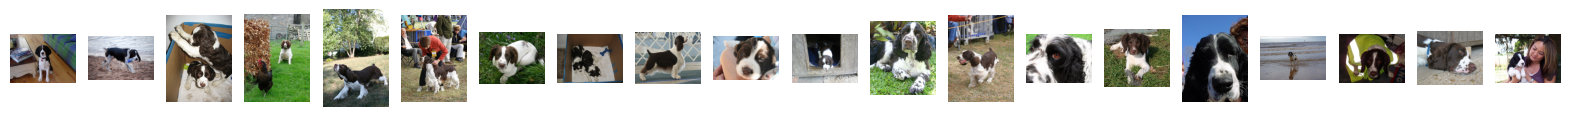

In [43]:
import matplotlib.pyplot as plt
import os

def print_examples(concept, save_directory):
    # Ensure the directory exists
    os.makedirs(save_directory, exist_ok=True)
    
    # Define the save path with a filename
    save_path = os.path.join(save_directory, 'example_plot.png')
    
    # Create the plot
    plt.figure(figsize=(20, 2))  # Adjust the figure size to ensure images are not distorted
    for i in range(0, 20):
        plt.subplot(1, 20, i + 1)
        plt.imshow(concept[i][0])
        plt.axis("off")

    # Save the plot
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    print(f"Plot saved to {save_path}")

    # Display the plot
    plt.show()

# Example usage
# Specify the directory path
save_directory = 'images_within_concept_pipeline/K_value_50/Concept_1/concept_images'
print_examples(concept_images_labels[1], save_directory)


In [92]:
import os

# Define directories to search for fonts
font_dirs = [
    "/usr/share/fonts/",
    "/usr/local/share/fonts/",
    "/Library/Fonts/",
    "/System/Library/Fonts/",
    "C:\\Windows\\Fonts\\"
]

available_fonts = []

# Search for fonts in the specified directories
for font_dir in font_dirs:
    if os.path.exists(font_dir):
        for root, dirs, files in os.walk(font_dir):
            for file in files:
                if file.endswith(".ttf") or file.endswith(".otf"):
                    available_fonts.append(os.path.join(root, file))

# Print the available fonts
for font in available_fonts:
    print(font)


/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf


### Box plot of average value of each metric over all layers VS different relevance types, considering all 10 concepts and all their possible image pairs

In [11]:
def create_box_plots_for_all_concepts(main_path):
    # Set the style to 'default' for a clean and simple plot appearance
    plt.style.use('default')
    
    box_plot_output_path = os.path.join(main_path, f'K_value_50', f'All_Concepts_Box_Plots')
    if not os.path.exists(box_plot_output_path):
        os.makedirs(box_plot_output_path)
        
    # Step 1: Load and concatenate the CSV files for concepts 0 to 9
    concept_dfs = []
    for concept_num in range(10):
        concept_csv_path = os.path.join(main_path, f'K_value_50', f'Concept_{concept_num}', f'Metrics_Concept_{concept_num}_K_50.csv')
        concept_df = pd.read_csv(concept_csv_path)
        concept_df['concept_num'] = concept_num  # Add a column to track the concept number
        concept_dfs.append(concept_df)

    # Concatenate all DataFrames into one
    df = pd.concat(concept_dfs, ignore_index=True)

    # Step 2: Calculate the average metric over all layers
    layer_columns = [f'layer{layer_num}' for layer_num in range(1, 13)]
    df['avg_metric_over_layers'] = df[layer_columns].mean(axis=1)

    # Step 3: Save the DataFrame with the avg_metric_over_layers column as a CSV
    avg_metric_csv_path = os.path.join(main_path, f'K_value_50', f'All_Concepts_Box_Plots', 'All_Concepts_Boxplot_data.csv')
    df.to_csv(avg_metric_csv_path, index=False)
    print(f'DataFrame with avg_metric_over_layers saved as {avg_metric_csv_path}')

    # Step 4: Prepare to save data for CSV
    csv_data = []

    # Step 5: Generate box plots
    # Define the list of metrics and their display names
    metrics = {
        'sse': 'SSE',
        'cosine': 'Cosine Similarity',
        'dot': 'Dot Product',
        'sse_scaled': 'Scaled SSE',
        'dot_scaled': 'Scaled Dot Product'
    }

    # Loop through each metric and create box plots
    for metric, metric_name in metrics.items():
        # Create a subset DataFrame for the current metric
        sub_df = df[df['metric'] == metric]

        # Determine the unique relevance types in a consistent order
        relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]

        # Collect the 'avg_metric_over_layers' values for each relevance type
        data_to_plot = [sub_df[sub_df['relevance_type'] == relevance]['avg_metric_over_layers'].values for relevance in relevance_types]

        # Create the box plot
        plt.figure(figsize=(12, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True, labels=relevance_types)

        # Customize box colors
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lavender', 'lightyellow', 'lightgray']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Collect data for CSV
        for i, relevance in enumerate(relevance_types):
            if i >= len(box['medians']):  # Skip if there's no data for this relevance type
                continue

            # Data in the box (without outliers)
            data_in_box = [y for y in data_to_plot[i] if y >= box['whiskers'][2*i].get_ydata()[1] and y <= box['whiskers'][2*i+1].get_ydata()[1]]
            no_of_data_in_box = len(data_in_box)

            # Outliers
            outliers = [y for y in data_to_plot[i] if y < box['whiskers'][2*i].get_ydata()[1] or y > box['whiskers'][2*i+1].get_ydata()[1]]
            no_of_outliers = len(outliers)

            csv_data.append({
                'metric': metric_name,
                'relevance_type': relevance,
                'no_of_data_in_box': no_of_data_in_box,
                'no_of_outliers': no_of_outliers
            })

        # Set titles and labels without transparency issues
        plt.title(f'Box Plot of {metric_name} for Different Relevance Types Across All Concepts', fontsize=14)
        plt.xlabel('Relevance Type', fontsize=12)
        plt.ylabel(f'Average {metric_name} Over Layers', fontsize=12)

        # Rotate x-axis labels for better visibility
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to ensure everything fits without overlap
        plt.tight_layout()

        # Save and display the plot
        saving = os.path.join(box_plot_output_path, f'boxplot_{metric}.png')
        plt.savefig(saving)
        plt.show()

        print(f'Box plot for {metric_name} saved as boxplot_{metric}.png')

    # Step 6: Save the summary CSV data
    csv_output_path = os.path.join(box_plot_output_path, 'boxplot_data_summary.csv')
    pd.DataFrame(csv_data).to_csv(csv_output_path, index=False)
    print(f'Data for box plots saved as {csv_output_path}')

DataFrame with avg_metric_over_layers saved as images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv


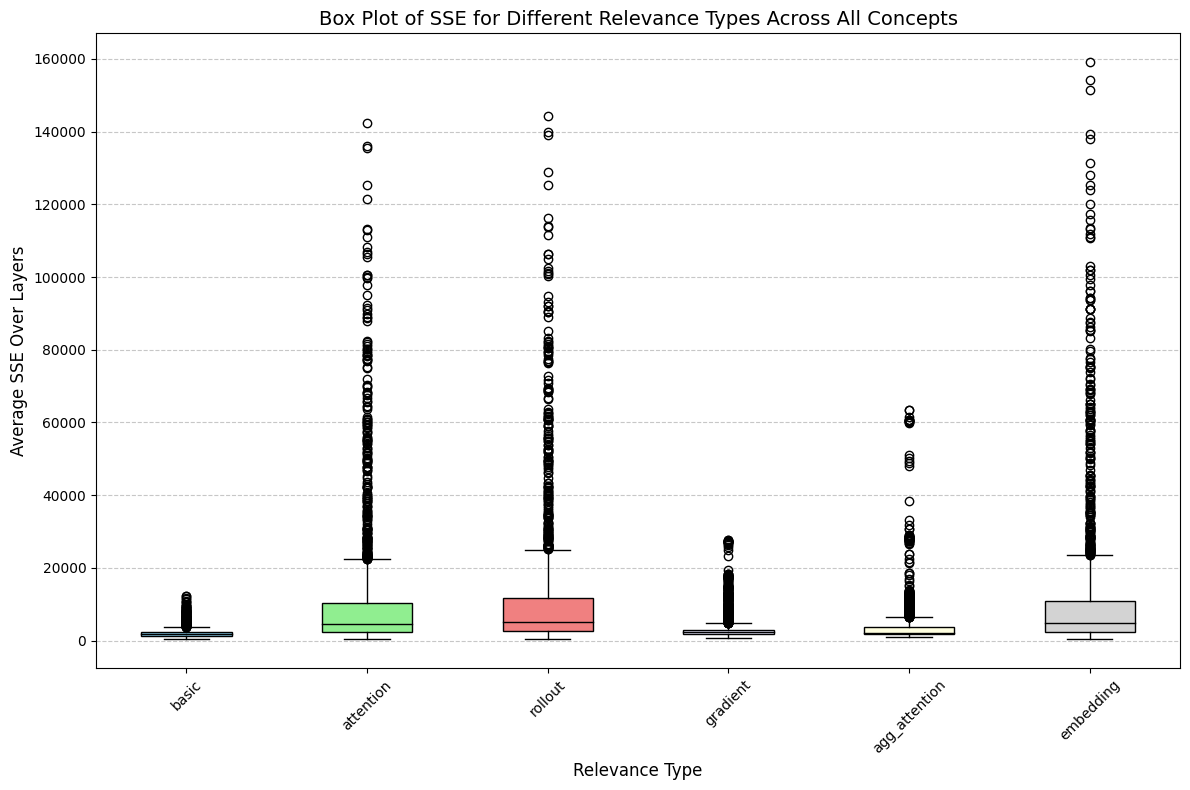

Box plot for SSE saved as boxplot_sse.png


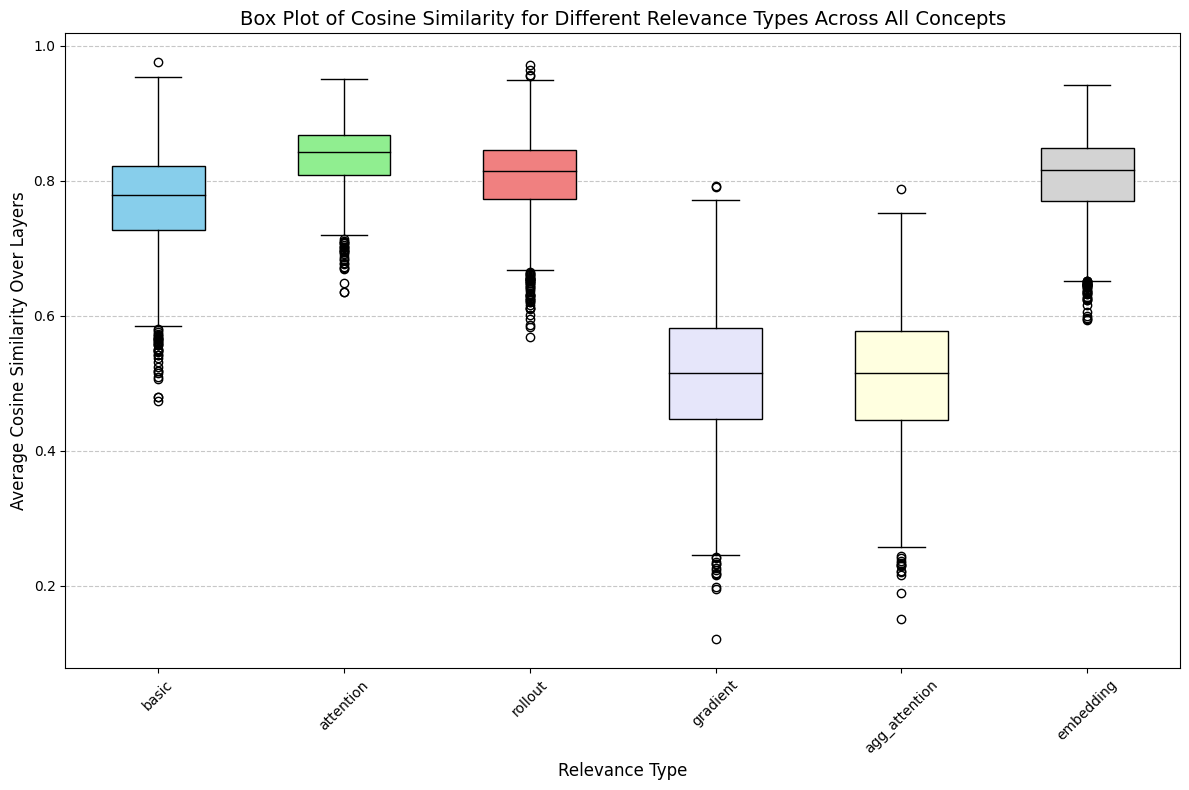

Box plot for Cosine Similarity saved as boxplot_cosine.png


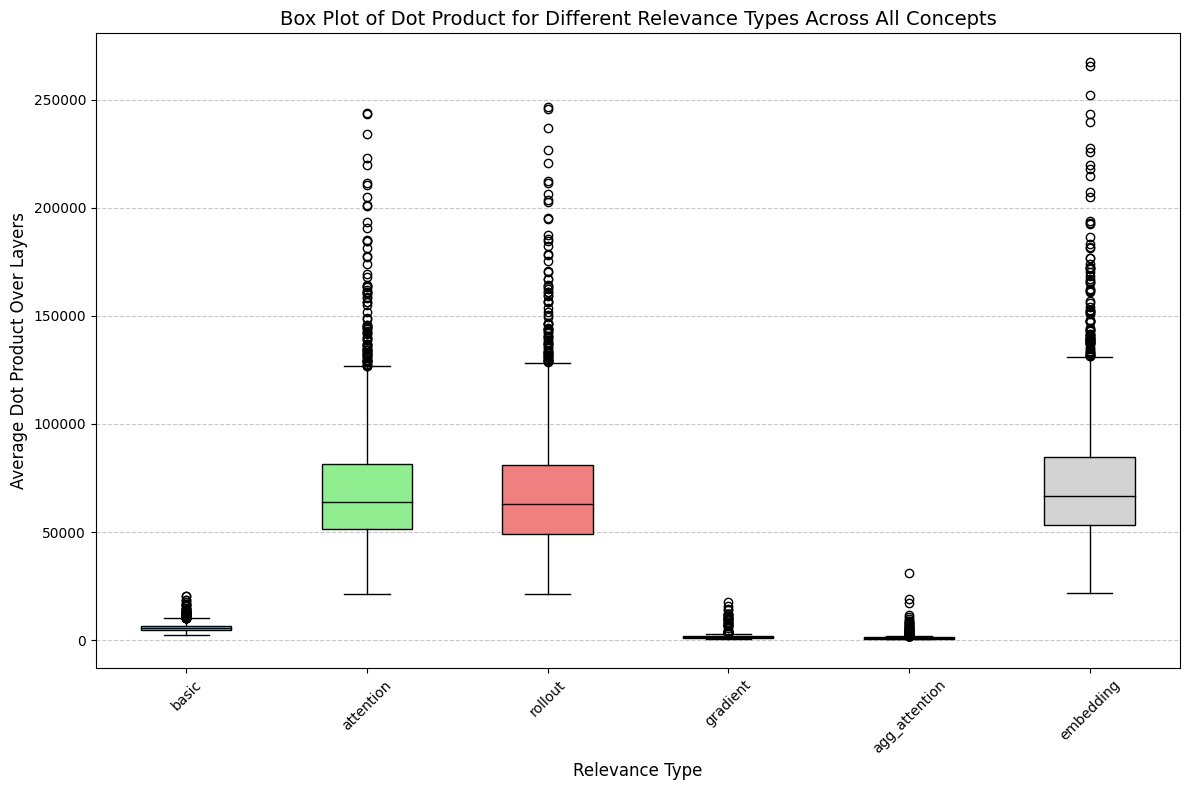

Box plot for Dot Product saved as boxplot_dot.png


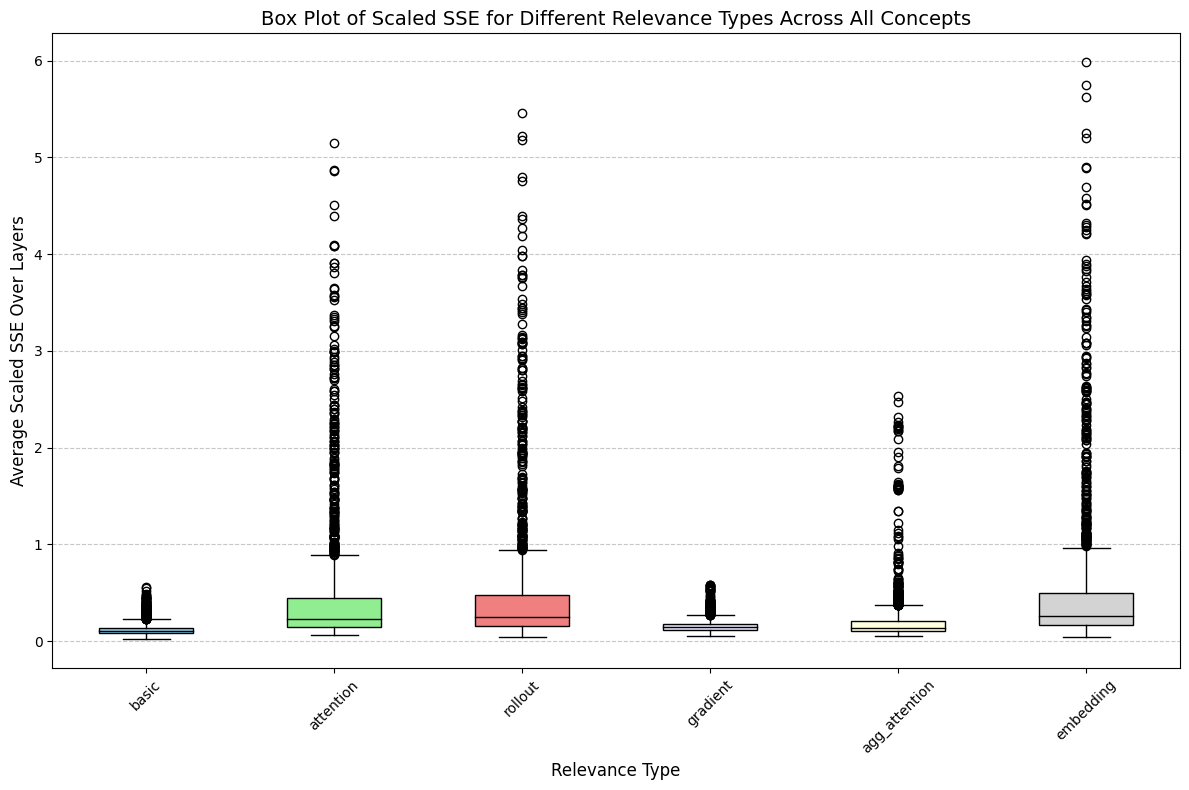

Box plot for Scaled SSE saved as boxplot_sse_scaled.png


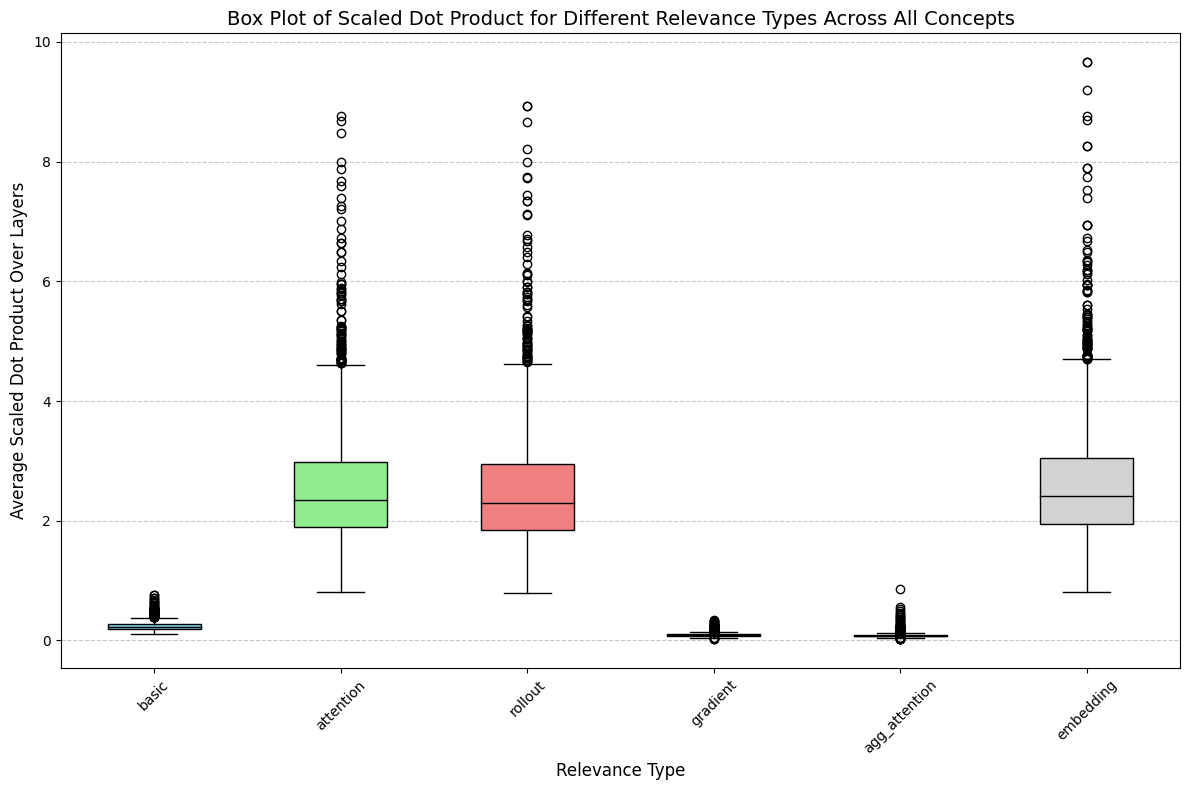

Box plot for Scaled Dot Product saved as boxplot_dot_scaled.png
Data for box plots saved as images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/boxplot_data_summary.csv


In [12]:
# Example usage:
main_path = 'images_within_concept_pipeline'
create_box_plots_for_all_concepts(main_path)

In [13]:
def create_box_plots_for_all_concepts_without_outliers(main_path):
    # Set the style to 'default' for a clean and simple plot appearance
    plt.style.use('default')
    
    # Step 1: Load and concatenate the CSV files for concepts 0 to 9
    concept_dfs = []
    for concept_num in range(10):
        concept_csv_path = os.path.join(main_path, f'K_value_50', f'Concept_{concept_num}', f'Metrics_Concept_{concept_num}_K_50.csv')
        concept_df = pd.read_csv(concept_csv_path)
        concept_df['concept_num'] = concept_num  # Add a column to track the concept number
        concept_dfs.append(concept_df)

    # Concatenate all DataFrames into one
    df = pd.concat(concept_dfs, ignore_index=True)

    # Step 2: Calculate the average metric over all layers
    layer_columns = [f'layer{layer_num}' for layer_num in range(1, 13)]
    df['avg_metric_over_layers'] = df[layer_columns].mean(axis=1)

    # Step 3: Generate box plots without outliers
    box_plot_output_path = os.path.join(main_path, f'K_value_50', f'All_Concepts_Box_Plots')
    if not os.path.exists(box_plot_output_path):
        os.makedirs(box_plot_output_path)

    # Define the list of metrics and their display names
    metrics = {
        'sse': 'SSE',
        'cosine': 'Cosine Similarity',
        'dot': 'Dot Product',
        'sse_scaled': 'Scaled SSE',
        'dot_scaled': 'Scaled Dot Product'
    }

    # Loop through each metric and create box plots
    for metric, metric_name in metrics.items():
        # Create a subset DataFrame for the current metric
        sub_df = df[df['metric'] == metric]

        # Determine the unique relevance types in a consistent order
        relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]

        # Collect the 'avg_metric_over_layers' values for each relevance type
        data_to_plot = [sub_df[sub_df['relevance_type'] == relevance]['avg_metric_over_layers'].values for relevance in relevance_types]

        # Create the box plot without outliers
        plt.figure(figsize=(12, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True, labels=relevance_types, showfliers=False)

        # Customize box colors
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lavender', 'lightyellow', 'lightgray']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels without transparency issues
        plt.title(f'Box Plot of {metric_name} for Different Relevance Types Across All Concepts', fontsize=14)
        plt.xlabel('Relevance Type', fontsize=12)
        plt.ylabel(f'Average {metric_name} Over Layers', fontsize=12)

        # Rotate x-axis labels for better visibility
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to ensure everything fits without overlap
        plt.tight_layout()

        # Save and display the plot with a different filename to avoid overwriting
        saving = os.path.join(box_plot_output_path, f'boxplot_{metric}_no_outliers.png')
        plt.savefig(saving)
        plt.show()

        print(f'Box plot for {metric_name} without outliers saved as boxplot_{metric}_no_outliers.png')

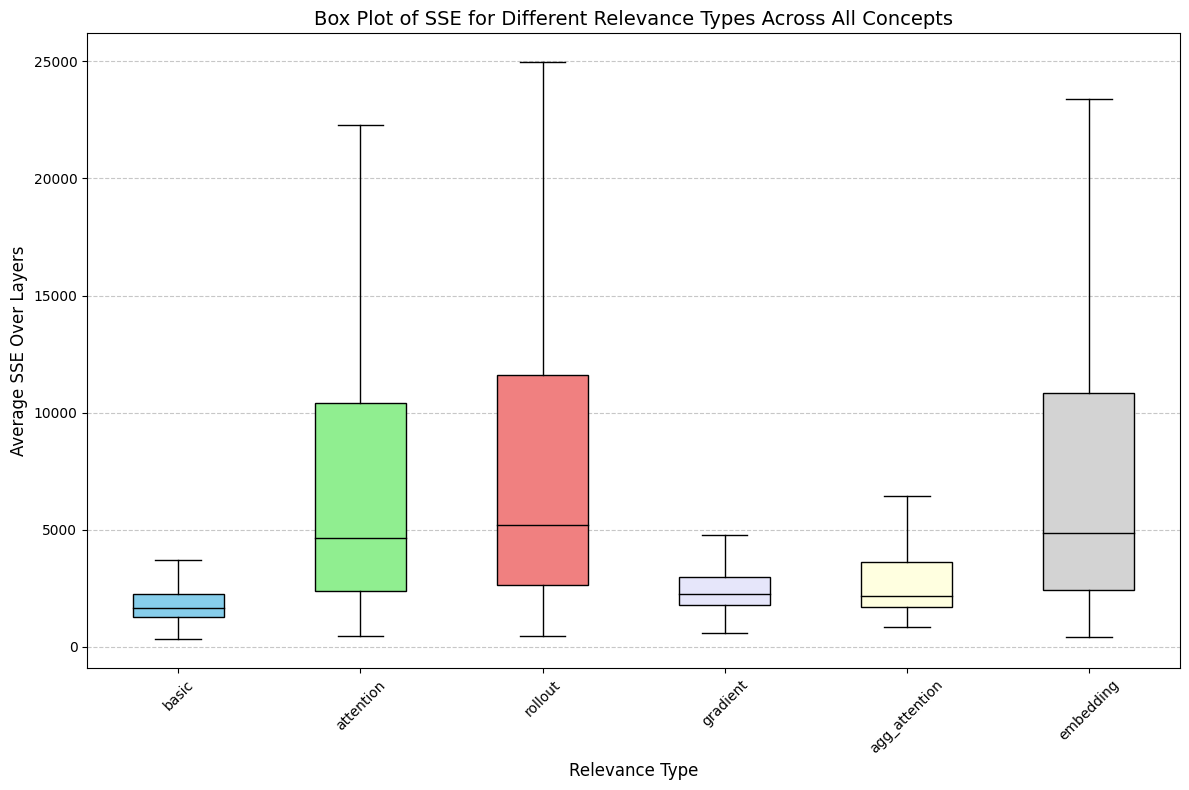

Box plot for SSE without outliers saved as boxplot_sse_no_outliers.png


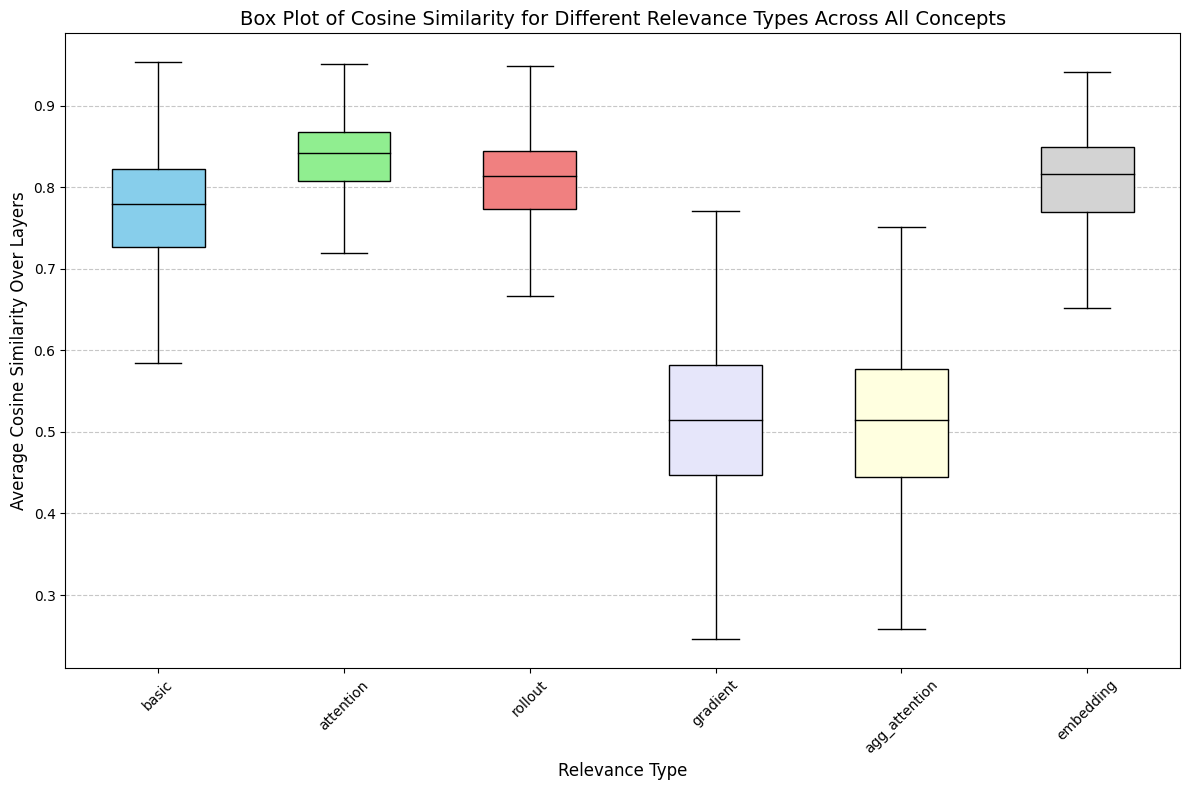

Box plot for Cosine Similarity without outliers saved as boxplot_cosine_no_outliers.png


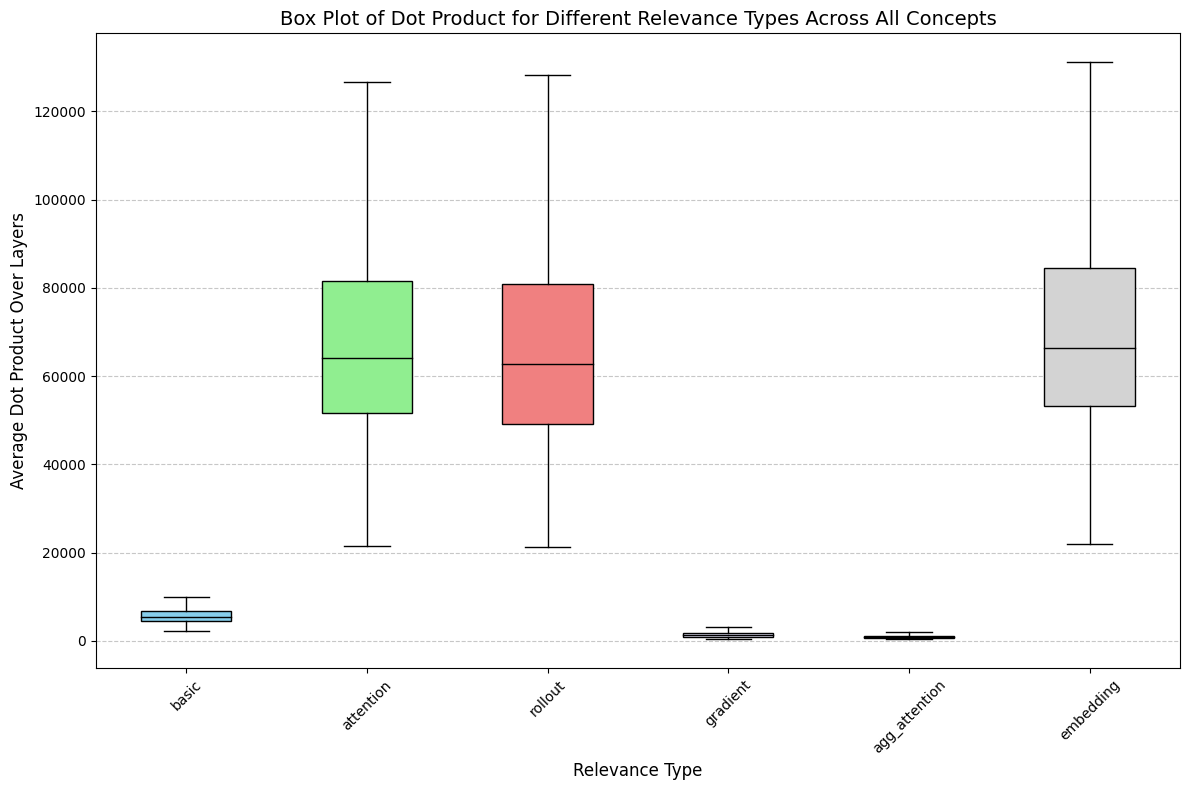

Box plot for Dot Product without outliers saved as boxplot_dot_no_outliers.png


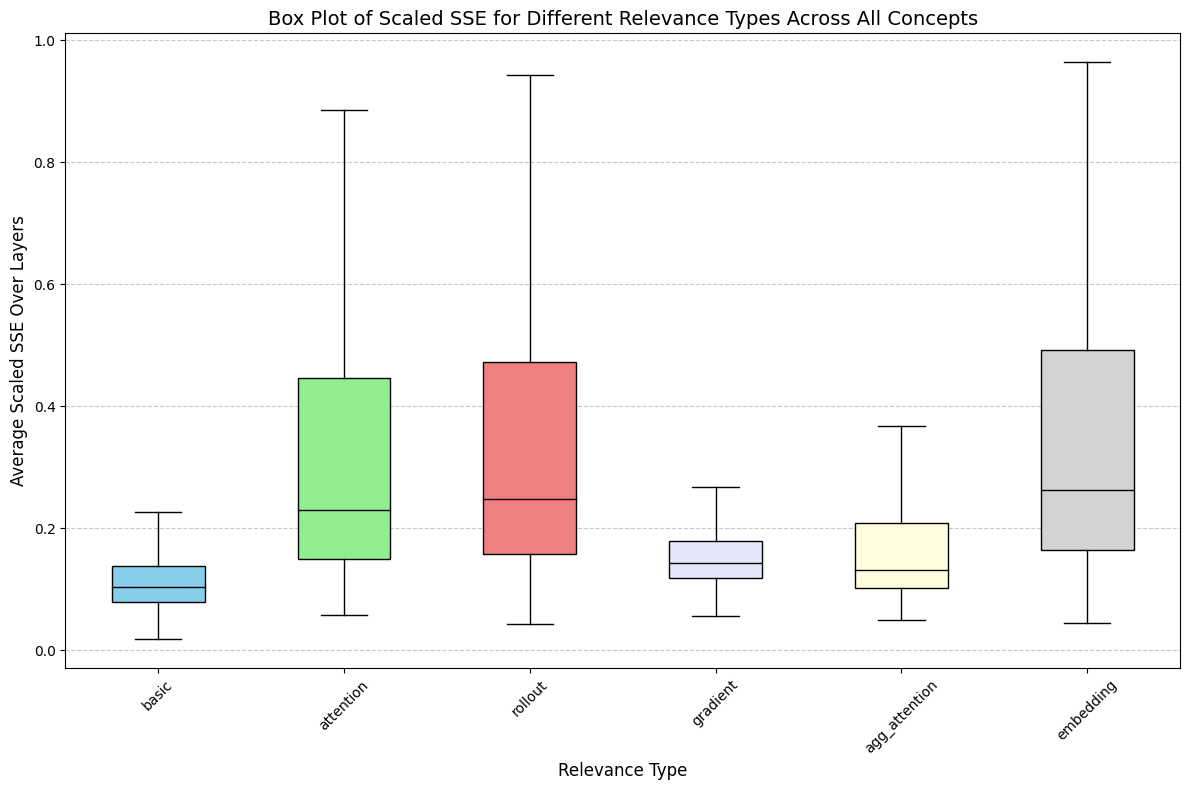

Box plot for Scaled SSE without outliers saved as boxplot_sse_scaled_no_outliers.png


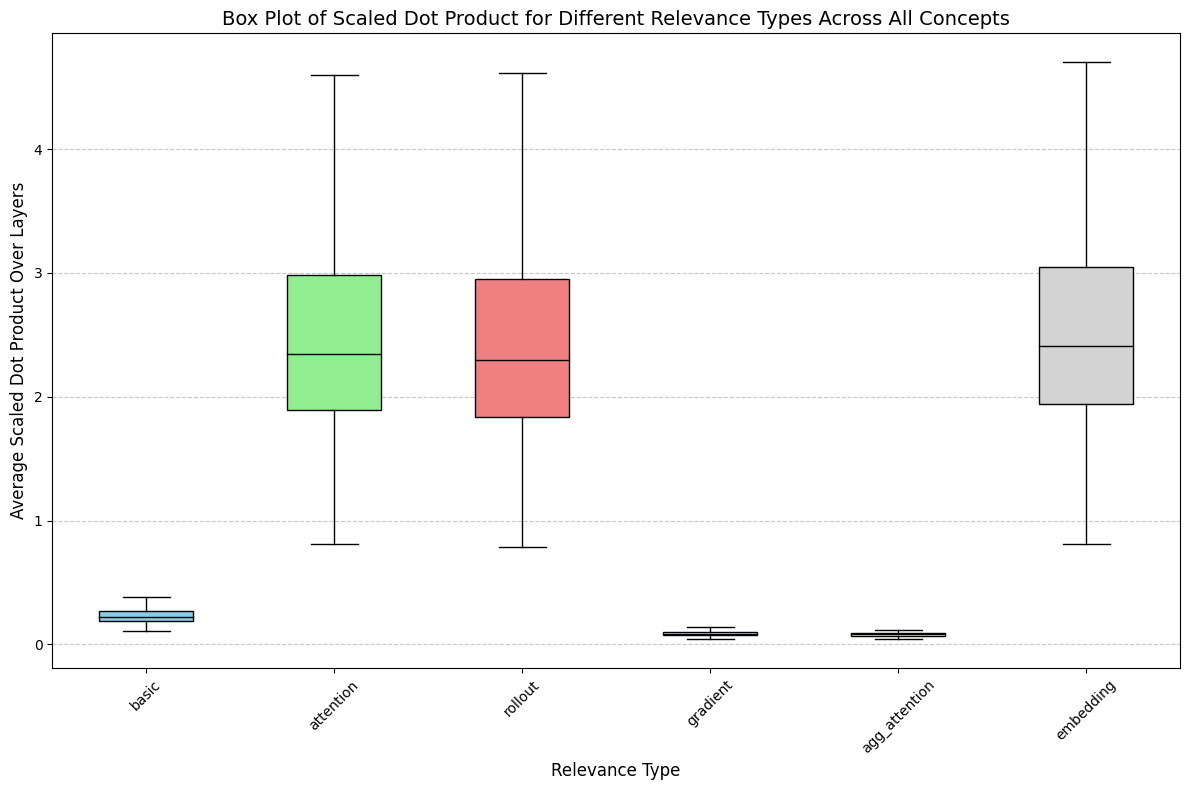

Box plot for Scaled Dot Product without outliers saved as boxplot_dot_scaled_no_outliers.png


In [14]:
main_path = 'images_within_concept_pipeline'
create_box_plots_for_all_concepts_without_outliers(main_path)